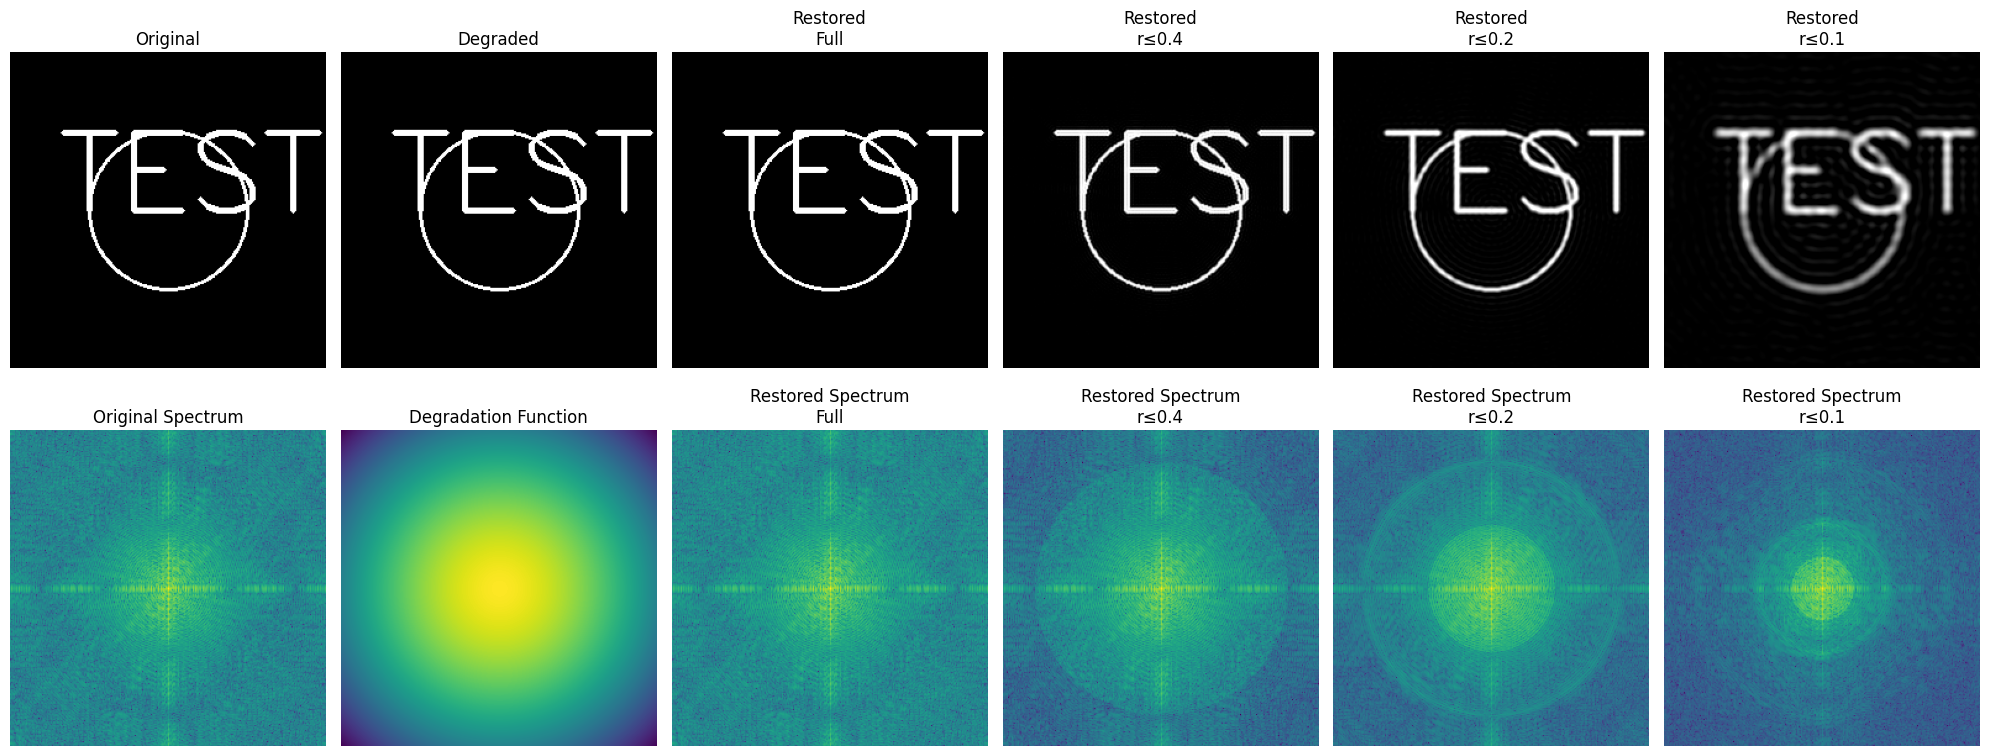

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_frequency_grid(M, N):
    """Create frequency grid for MxN image."""
    u = np.fft.fftfreq(M)
    v = np.fft.fftfreq(N)
    u, v = np.meshgrid(u, v)
    return u, v

def atmospheric_degradation(u, v, k=0.0025):
    """
    Atmospheric turbulence degradation function
    H(u,v) = exp(-k((u-M/2)^2 + (v-N/2)^2)^(5/6))
    """
    r_squared = (u**2 + v**2)
    H = np.exp(-k * (r_squared)**(5/6))
    return H

def inverse_filter_truncated(G, H, radius=None):
    """
    Apply inverse filter with optional frequency truncation.
    radius: cutoff radius in frequency domain (None for full inverse)
    """
    if radius is None:
        # Full inverse filtering
        F_hat = G / (H + 1e-10)  # Small constant to avoid division by zero
    else:
        # Create frequency distance mask
        M, N = G.shape
        u, v = create_frequency_grid(M, N)
        r = np.sqrt(u**2 + v**2)
        mask = r <= radius

        # Apply truncated inverse filter
        F_hat = np.zeros_like(G, dtype=complex)
        F_hat[mask] = G[mask] / (H[mask] + 1e-10)

    return F_hat

def process_image(image, k=0.0025, noise_std=0.01, radii=[None, 0.4, 0.2, 0.1]):
    """Process image with different inverse filter cutoff radii."""
    # Convert to float
    img_float = image.astype(float) / 255.0

    # Get frequency grid
    M, N = image.shape
    u, v = create_frequency_grid(M, N)

    # Calculate degradation function
    H = atmospheric_degradation(u, v, k)

    # Apply degradation
    F = np.fft.fft2(img_float)
    G = H * F

    # Add noise in frequency domain
    noise = np.random.normal(0, noise_std, G.shape) + 1j * np.random.normal(0, noise_std, G.shape)
    G = G + noise

    # Get degraded image
    g = np.real(np.fft.ifft2(G))
    degraded = np.clip(g * 255, 0, 255).astype(np.uint8)

    # Apply inverse filtering with different radii
    results = []
    for radius in radii:
        F_hat = inverse_filter_truncated(G, H, radius)
        f_hat = np.real(np.fft.ifft2(F_hat))
        restored = np.clip(f_hat * 255, 0, 255).astype(np.uint8)
        results.append(restored)

    return degraded, results, H

def visualize_results(original, degraded, restored_images, H, radii=[None, 0.4, 0.2, 0.1]):
    """Visualize original, degraded, and restored images."""
    n_images = len(restored_images) + 2  # +2 for original and degraded
    fig, axes = plt.subplots(2, n_images, figsize=(20, 8))

    # First row: Images
    axes[0,0].imshow(original, cmap='gray')
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    axes[0,1].imshow(degraded, cmap='gray')
    axes[0,1].set_title('Degraded')
    axes[0,1].axis('off')

    for i, (restored, radius) in enumerate(zip(restored_images, radii)):
        axes[0,i+2].imshow(restored, cmap='gray')
        radius_text = 'Full' if radius is None else f'r≤{radius}'
        axes[0,i+2].set_title(f'Restored\n{radius_text}')
        axes[0,i+2].axis('off')

    # Second row: Frequency spectra
    axes[1,0].imshow(np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(original)))), cmap='viridis')
    axes[1,0].set_title('Original Spectrum')
    axes[1,0].axis('off')

    axes[1,1].imshow(np.log1p(np.abs(np.fft.fftshift(H))), cmap='viridis')
    axes[1,1].set_title('Degradation Function')
    axes[1,1].axis('off')

    for i, (restored, radius) in enumerate(zip(restored_images, radii)):
        spectrum = np.fft.fftshift(np.fft.fft2(restored))
        axes[1,i+2].imshow(np.log1p(np.abs(spectrum)), cmap='viridis')
        radius_text = 'Full' if radius is None else f'r≤{radius}'
        axes[1,i+2].set_title(f'Restored Spectrum\n{radius_text}')
        axes[1,i+2].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Create or load test image
    image = cv2.imread('your_image.jpg', cv2.IMREAD_GRAYSCALE)
    if image is None:
        # Create test image
        image = np.zeros((256, 256), dtype=np.uint8)
        cv2.putText(image, 'TEST', (40, 128), cv2.FONT_HERSHEY_SIMPLEX, 3, 255, 4)
        cv2.circle(image, (128, 128), 64, 255, 2)

    # Process image with different cutoff radii
    degraded, restored_images, H = process_image(
        image,
        k=0.001,  # Degradation strength
        noise_std=0.01,  # Noise level
        radii=[None, 0.4, 0.2, 0.1]  # Cutoff radii
    )

    # Visualize results
    visualize_results(image, degraded, restored_images, H)

if __name__ == "__main__":
    main()